In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import xarray as xr

### Read fluxes

In [2]:
def read_fluxes (heat_data_file='heatflux.dat', momentum_data_file='momentumflux.dat',
                 datetimeformat='%Y/%m/%d %H:%M:%S'):

    # Use read_csv to read the file
    df1 = pd.read_csv(heat_data_file, sep='\s+', header=None, names=['date', 'time', 'Q'])
    # Combine the 'date' and 'time' columns into a single 'datetime' column
    df1['datetime'] = df1['date'] + ' ' + df1['time']
    # Convert 'datetime' column to datetime format
    df1['datetime'] = pd.to_datetime(df1['datetime'], format=datetimeformat)
    # Drop the separate 'date' and 'time' columns if they are no longer needed
    df1.drop(columns=['date', 'time'], inplace=True)
    # Combine the date and time columns if necessary
    # Ensure 'datetime' column is in the correct format
    df1['datetime'] = pd.to_datetime(df1['datetime'], format=datetimeformat)
    
    df2 = pd.read_csv(momentum_data_file, sep='\s+', header=None, names=['date', 'time', 'taux', 'tauy'])
    df2['datetime'] = df2['date'] + ' ' + df2['time']
    df2['datetime'] = pd.to_datetime(df2['datetime'], format=datetimeformat)
    df2.drop(columns=['date', 'time'], inplace=True)
    df2['datetime'] = pd.to_datetime(df2['datetime'], format=datetimeformat)

    df = pd.merge(df1, df2, on='datetime')
    df = df[['datetime','Q','taux','tauy']]
    
    xrdf = xr.Dataset(
    {'taux': (['t'], df.taux),
    'tauy': (['t'], df.tauy),
    'Q': (['t'], df.Q)},
    coords={
        "t": df.datetime,
    },)
    
    return xrdf

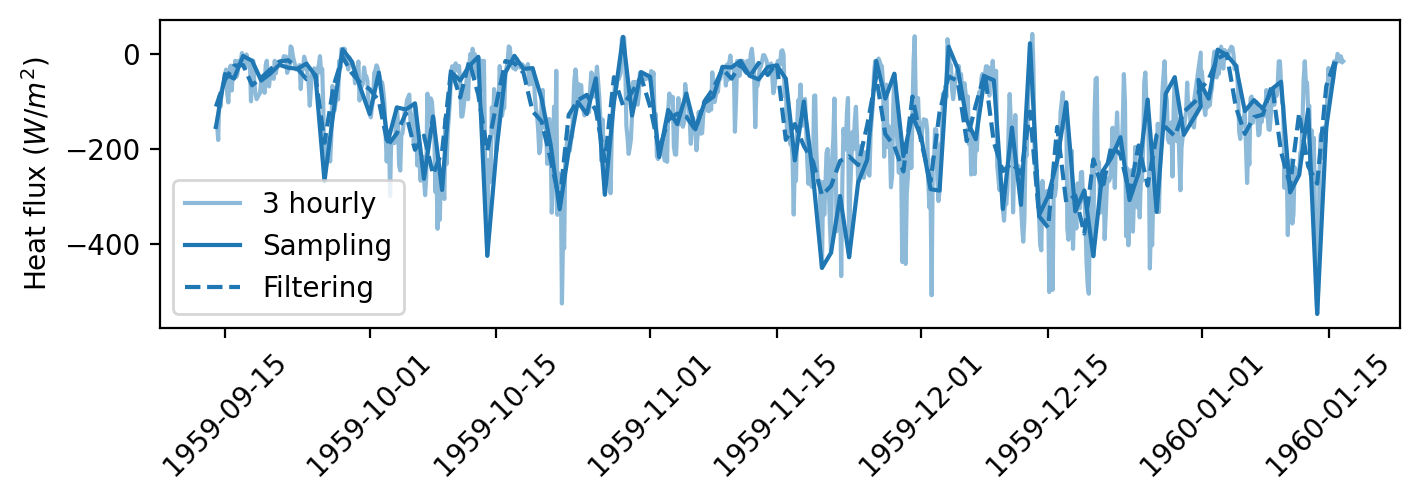

In [8]:
fig = plt.figure(figsize=[8,2],dpi=200)
ax = plt.gca()

df = read_fluxes(heat_data_file='heatflux.dat', momentum_data_file='momentumflux.dat',
                 datetimeformat='%Y/%m/%d %H:%M:%S')

Q_hat = df.Q.coarsen({'t':8}, boundary='trim').mean()
ax.plot(df.t[:1000], df.Q[:1000], alpha=0.5, label='3 hourly')
ax.plot(df.t[:1000:8], df.Q[:1000:8], c='C0', alpha=1, label='Sampling')
ax.plot(df.t[:1000:8], Q_hat[:125], '--', c='C0', alpha=1, label='Filtering')

ax.set_ylabel(r'Heat flux ($W/m^2$)')
plt.setp(ax.get_xticklabels(), rotation=45)
plt.legend()
plt.show()

### Flux output (after manipulation)
Write the filtered flux back into a text file with original format

In [ ]:
time_ = df1['datetime'].dt.strftime('%Y/%m/%d %H:%M:%S')

# Merge DataFrames on their index (the "time" coordinate in this case)
Q_hat_pd = pd.merge(Q_hat.t.to_dataframe(), Q_hat.to_dataframe(), left_index=True, right_index=True)
Q_hat_pd.to_csv("heatflux_filter1day.txt", sep=' ', header=False, index=False)

### Repeat this for post 2010 files
Coarsen from approximately hourly to 3-hourly. We have updated the read-in file to include all variables.

In [7]:
from mlflux.gotm import read2010
path = '/home/jw8736/code-5.2.1/cases/ows_papa/'
df = read2010(path, datetimeformat='%Y-%m-%d %H:%M:%S')

In [9]:
df

,datetime,sst,ux,uy,t,p,q,taux,tauy,Q,swr,lwr,U,rh,cos,sin
0,2010-01-01 00:00:00,6.3960,-4.361870,-9.53051,6.18604,99692.8,0.005925,-0.074978,-0.163824,-9.68961,31.671900,-6.57526,10.481247,99.485462,-0.416159,-0.909292
1,2010-01-01 01:00:00,6.3950,-5.074300,-9.48621,6.22940,99773.2,0.005928,-0.090532,-0.169245,-11.34850,11.368200,-9.30572,10.758099,99.322111,-0.471673,-0.881774
2,2010-01-01 02:00:00,6.3930,-4.142170,-9.15108,6.16396,99864.3,0.005897,-0.067179,-0.148416,-12.33640,0.419238,-8.46656,10.044891,99.337234,-0.412366,-0.911018
3,2010-01-01 03:00:00,6.3920,-3.660650,-9.62396,6.22857,99946.9,0.005914,-0.061469,-0.161605,-10.14730,0.000000,-8.10829,10.296648,99.265154,-0.355519,-0.934669
4,2010-01-01 04:00:00,6.3910,-3.343630,-10.13180,6.27692,100020.0,0.005922,-0.059054,-0.178943,-9.80548,0.000000,-9.03184,10.669266,99.134242,-0.313389,-0.949625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86307,2020-12-27 00:00:00,7.7673,-2.265070,-4.36358,7.04185,100560.0,0.004418,-0.014797,-0.028505,-148.59200,104.259000,-104.55800,4.916439,70.606978,-0.460714,-0.887549
86308,2020-12-27 01:00:00,7.7541,-1.586550,-4.45919,7.13759,100720.0,0.004336,-0.009892,-0.027802,-144.50500,41.751900,-101.74900,4.733024,68.955587,-0.335209,-0.942144
86309,2020-12-27 02:00:00,7.7528,-0.827859,-4.13077,7.23596,100880.0,0.004398,-0.004520,-0.022554,-110.29900,2.595340,-73.19700,4.212910,69.589658,-0.196505,-0.980503
86310,2020-12-27 03:00:00,7.7533,-1.371070,-3.13455,7.13849,100990.0,0.004440,-0.006032,-0.013791,-121.96100,0.000000,-92.15760,3.421292,70.789259,-0.400746,-0.916189


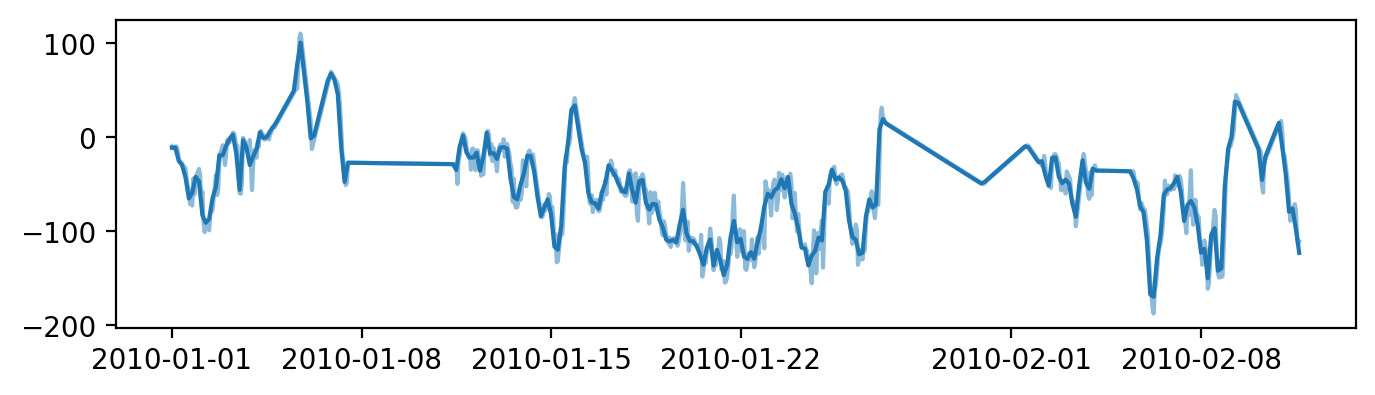

In [10]:
# Read the data file
# Adjust the file path as needed
df_ = df.set_index('datetime')
ds = xr.Dataset.from_dataframe(df_)
ds_uniform = ds.resample(datetime='H').interpolate('linear') # Interpolation non-uniform to hourly
ds_hat = ds_uniform.resample(datetime='3H').mean() # Coarsening to 3-hourly

fig = plt.figure(figsize=[8,2],dpi=200)
ax = plt.gca()
ax.plot(ds_uniform.datetime[:1000], ds_uniform.Q[:1000], alpha=0.5, label='hourly')
ax.plot(ds_hat.datetime[:334], ds_hat.Q[:334], c='C0', alpha=1, label='3 hourly filtering')

In [72]:
# Specify the output file
path = '/home/jw8736/test-gotm/2012/'

output_file = path + 'heat_flux_3hourly_bulk.dat'
# Write the datetime and values to the file, row by row
with open(output_file, 'w') as file:
    for t, val in zip(ds_hat.t.values, ds_hat.Q.values):
        datetime_string = pd.to_datetime(t).strftime('%Y-%m-%d %H:%M:%S')
        file.write(f"{datetime_string}\t{val:.8f}\n")

output_file = path + 'momentum_flux_3hourly_bulk.dat'
with open(output_file, 'w') as file:
    for t, val1, val2 in zip(ds_hat.t.values, ds_hat.taux.values, ds_hat.tauy.values,):
        datetime_string = pd.to_datetime(t).strftime('%Y-%m-%d %H:%M:%S')
        file.write(f"{datetime_string}\t{val1:.8f}\t{val2:.8f}\n")

In [12]:
path = '/home/jw8736/test-gotm/2012/'
output_file = path + 'swr_3hourly_bulk.dat'
with open(output_file, 'w') as file:
    for t, val in zip(ds_hat.datetime.values, ds_hat.swr.values):
        datetime_string = pd.to_datetime(t).strftime('%Y-%m-%d %H:%M:%S')
        file.write(f"{datetime_string}\t{val:.8f}\n")

### Read state variables (post 2010) and apply ANN to compute fluxes

In [ ]:
meteo_era5.dat
start: 2011-03-21 00:00:00           # start date and time [yyyy-mm-dd HH:MM:SS; default=2017-01-01 00:00:00]
stop: 2020-03-21 00:00:00            # stop date and time [yyyy-mm-dd HH:MM:SS; default=2018-01-01 00:00:00]

In [ ]:
# See timeseries.ipynb
# TODO: merge the two

### Check the two files

Text(0, 0.5, '$Q_{total} (W/m^2)$')

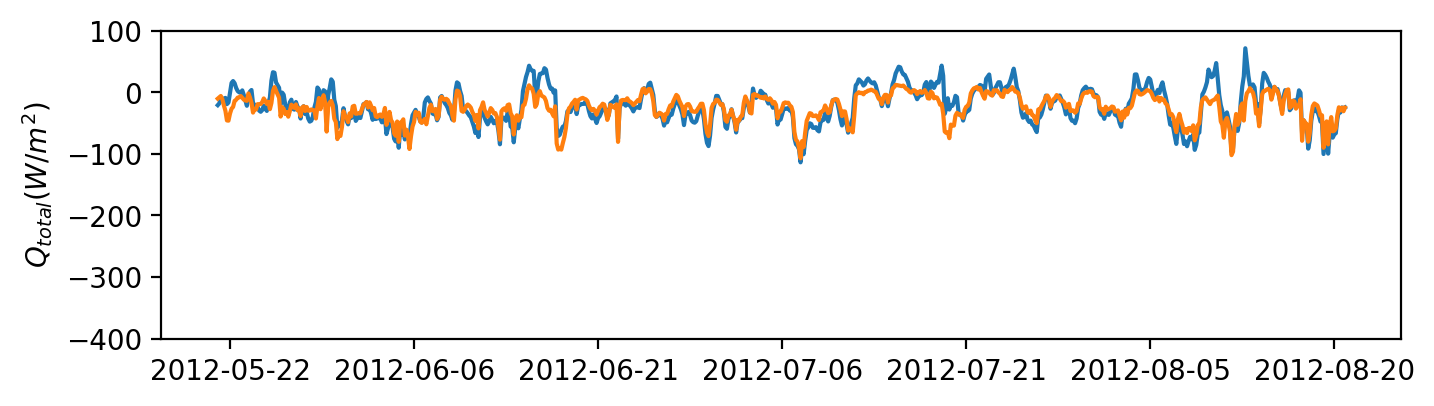

In [3]:
# Read the data file
# Adjust the file path as needed
path = '/home/jw8736/test-gotm/2012/'

heat_data_file = path + 'heat_flux_3hourly_bulk.dat'
momentum_data_file = path + 'momentum_flux_3hourly_bulk.dat'
df_bulk = read_fluxes(heat_data_file, momentum_data_file,
                 datetimeformat='%Y-%m-%d %H:%M:%S') 

heat_data_file = path + 'heat_flux_3hourly_ann.dat'
momentum_data_file = path + 'momentum_flux_3hourly_ann.dat'
df_ann = read_fluxes(heat_data_file, momentum_data_file,
                 datetimeformat='%Y-%m-%d %H:%M:%S') 


fig = plt.figure(figsize=[8,2],dpi=200)
ax = plt.gca()

# sd = '2012-03-21'; ed = '2012-05-20'
sd = '2012-05-21'; ed = '2012-08-20'

# Select data within the date range
ax.plot(df_bulk.t.sel(t=slice(sd, ed)), df_bulk.Q.sel(t=slice(sd, ed)), alpha=1, label='bulk')
ax.plot(df_ann.t.sel(t=slice(sd, ed)), df_ann.Q.sel(t=slice(sd, ed)), alpha=1, label='ann')

import matplotlib.dates as mdates
ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))

ax.set_ylim(-400,100); plt.ylabel('$Q_{total} (W/m^2)$')
# plt.legend()